In [22]:
import tensorflow as tf

In [23]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))

In [24]:
for  item in dataset:
  print(item.numpy())

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]


In [25]:
dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window: window.batch(5))
dataset = dataset.map(lambda window: (window[:-1],window[-1,]))

In [26]:


dataset = tf.data.Dataset.range(10)
dataset = dataset.window(5, shift=1, drop_remainder=True)
# The flat_map operation is already converting the windows into batches of 5
# We want to apply the transformation to each element within the window
# So, we need to use map and then batch
dataset = dataset.map(lambda window: window.batch(5)) # Map each window to a batched dataset
dataset = dataset.flat_map(lambda window_batch: window_batch.map(lambda window: (window[:-1], window[-1:]))) # Unpack and apply transformation
                                                                                                             # window[-1:] instead of window[-1,]


# Now you can iterate and print:
for x,y in dataSet:
  print(x.numpy())
  print(y.numpy())

[[0 1 2 3]
 [5 6 7 8]]
[[4]
 [9]]
[[1 2 3 4]
 [2 3 4 5]]
[[5]
 [6]]
[[4 5 6 7]
 [3 4 5 6]]
[[8]
 [7]]


In [27]:
dataset = dataset.shuffle(buffer_size=10)
dataset = dataset.batch(2).prefetch(1)

In [28]:
for x,y in dataset:
  print("x = " , x.numpy())
  print("y = " , y.numpy())

x =  [[3 4 5 6]
 [4 5 6 7]]
y =  [[7]
 [8]]
x =  [[5 6 7 8]
 [0 1 2 3]]
y =  [[9]
 [4]]
x =  [[2 3 4 5]
 [1 2 3 4]]
y =  [[6]
 [5]]


In [29]:
import numpy as np

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4,
            np.cos(season_time * 2 * np.pi),
            1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)


def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

In [30]:
time = np.arange(4*365+1,dtype="float32")

baseline = 10
series = trend(time, .05)
amplitude = 15
slope=0.09
noise_level = 6

series = baseline+trend(time,slope)+seasonality(time,period=365,
                                                amplitude=amplitude)
series +=noise(time, noise_level, seed = 42)

In [31]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size+1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size+1))
    dataset = dataset.shuffle(shuffle_buffer)
    dataset = dataset.map(lambda window: (window[:-1], window[-1]))
    dataset  = dataset.batch(batch_size).prefetch(1)
    return dataset

In [32]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

In [36]:
window_size = 20 # Example value, adjust as needed
batch_size = 32 # Example value, adjust as needed
shuffle_buffer_size = 1000 # Example value, adjust as needed

dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [37]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

In [40]:
 model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(10, input_shape=[window_size], activation="relu"),
    tf.keras.layers.Dense(10, activation="relu"),
    tf.keras.layers.Dense(1)])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam()
)


In [43]:
model.fit(dataset,epochs=100)

Epoch 1/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 565.4760
Epoch 2/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 78.7135
Epoch 3/100


/usr/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 76.4363
Epoch 4/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.6591
Epoch 5/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.0400
Epoch 6/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 72.0319
Epoch 7/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 70.1520
Epoch 8/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 71.7470
Epoch 9/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.9338
Epoch 10/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 68.9045
Epoch 11/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 64.3750
Epoch 12/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 59.7693
Epoch 13/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 58.0388
Epoch 14/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 65.2631
Epoch 15/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 63.2799
Epoch 16/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 56.6531
Epoch 17/100
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 62.0132

In [44]:
series[1000:1020]

array([110.02661 , 107.25494 , 102.14167 ,  97.97915 , 106.12708 ,
       104.37574 , 107.46318 , 105.98035 , 108.54404 ,  99.112816,
       110.30619 , 103.66514 , 115.00891 ,  98.50013 , 113.129036,
       103.97882 ,  98.96105 , 100.04455 , 101.10417 , 105.64974 ],
      dtype=float32)

In [47]:
model.predict(series[1000:1020][np.newaxis])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step


array([[99.06282]], dtype=float32)

In [48]:
series[1020]

106.32034

In [49]:
forecast = []
for item in range(len(series)-window_size):
  forecast.append(model.predict(series[item:item+window_size][np.newaxis]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━

In [51]:
len(forecast)

1441

In [52]:
forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:,0,0]

In [56]:
import matplotlib.pyplot as plt

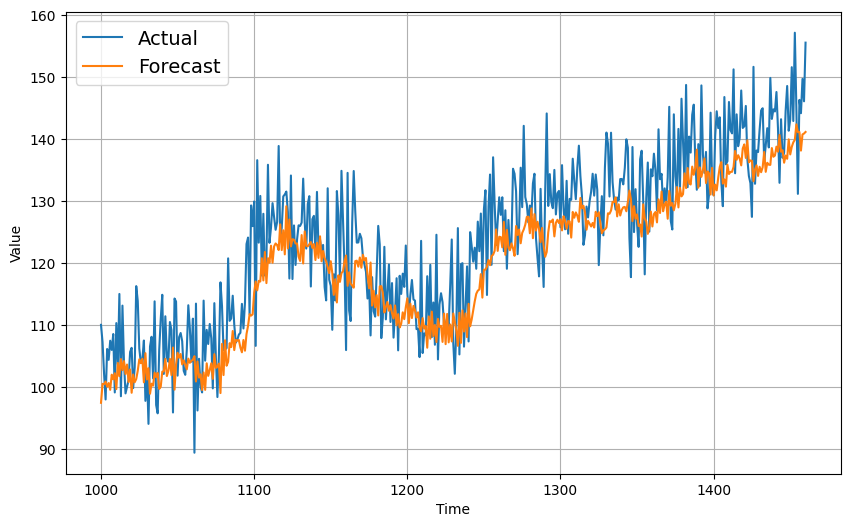

In [58]:
import matplotlib.pyplot as plt

def plot_series(time, series, format="-", start=0, end=None, label=None):
    """
    Plots a time series.

    Args:
        time (array-like): Time values for the series.
        series (array-like): Data values for the series.
        format (str, optional): Line format. Defaults to "-".
        start (int, optional): Start index for plotting. Defaults to 0.
        end (int, optional): End index for plotting. Defaults to None.
        label (str, optional): Label for the series. Defaults to None.
    """
    plt.plot(time[start:end], series[start:end], format, label=label)
    plt.xlabel("Time")
    plt.ylabel("Value")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# ... (your existing code) ...

# Now, call the plot_series function
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, label="Actual") # Added label for clarity
plot_series(time_valid, results, label="Forecast") # Added label for clarity
plt.show() # This line ensures the plot is displayed